In [36]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [3]:
!wget https://isic-challenge-data.s3.amazonaws.com/2018/ISIC2018_Task3_Training_Input.zip -q
!wget https://isic-challenge-data.s3.amazonaws.com/2018/ISIC2018_Task3_Training_GroundTruth.zip -q
!wget https://isic-challenge-data.s3.amazonaws.com/2018/ISIC2018_Task3_Validation_Input.zip -q
!wget https://isic-challenge-data.s3.amazonaws.com/2018/ISIC2018_Task3_Validation_GroundTruth.zip -q
!wget https://isic-challenge-data.s3.amazonaws.com/2018/ISIC2018_Task3_Test_Input.zip -q
!wget https://isic-challenge-data.s3.amazonaws.com/2018/ISIC2018_Task3_Test_GroundTruth.zip -q

In [4]:
!unzip 'ISIC2018_Task3_Training_Input.zip'
!unzip 'ISIC2018_Task3_Test_GroundTruth.zip'
!unzip 'ISIC2018_Task3_Test_Input.zip'
!unzip 'ISIC2018_Task3_Training_GroundTruth.zip'
!unzip 'ISIC2018_Task3_Validation_GroundTruth.zip'
!unzip 'ISIC2018_Task3_Validation_Input.zip'

Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.
  inflating: ISIC2018_Task3_Training_Input/ISIC_0031050.jpg  
 extracting: ISIC2018_Task3_Training_Input/ISIC_0031051.jpg  
 extracting: ISIC2018_Task3_Training_Input/ISIC_0031052.jpg  
 extracting: ISIC2018_Task3_Training_Input/ISIC_0031053.jpg  
 extracting: ISIC2018_Task3_Training_Input/ISIC_0031054.jpg  
 extracting: ISIC2018_Task3_Training_Input/ISIC_0031055.jpg  
  inflating: ISIC2018_Task3_Training_Input/ISIC_0031056.jpg  
 extracting: ISIC2018_Task3_Training_Input/ISIC_0031057.jpg  
  inflating: ISIC2018_Task3_Training_Input/ISIC_0031058.jpg  
  inflating: ISIC2018_Task3_Training_Input/ISIC_0031059.jpg  
  inflating: ISIC2018_Task3_Training_Input/ISIC_0031060.jpg  
 extracting: ISIC2018_Task3_Training_Input/ISIC_0031061.jpg  
  inflating: ISIC2018_Task3_Training_Input/ISIC_0031062.jpg  
 extracting: ISIC2018_Task3_Training_Input/ISIC_0031063.jpg  
  inflating: ISIC2018_Task3_Training_Input/ISIC_0031064.jpg  
  inflating: 

In [5]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import models, transforms, utils
import time
import copy
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
from sklearn.metrics import classification_report
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode

train_dir = 'ISIC2018_Task3_Training_Input/'
train_csv = '/content/ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv'
val_dir = 'ISIC2018_Task3_Validation_Input/'
val_csv = '/content/ISIC2018_Task3_Validation_GroundTruth/ISIC2018_Task3_Validation_GroundTruth.csv'
test_dir = 'ISIC2018_Task3_Test_Input/'
test_csv = '/content/ISIC2018_Task3_Test_GroundTruth/ISIC2018_Task3_Test_GroundTruth.csv'

save_checkpoint_path = '/content/drive/MyDrive/Colab Notebooks/Checkpoint/resnet101_isic_2018_2.pt'

dataset_dir = {'train' : train_dir, 'val' : val_dir}
dataset_csv = {'train' : train_csv, 'val' : val_csv}

raw_df = pd.read_csv(val_csv)
classes = list(raw_df.columns[1:])
num_classes = len(classes)

In [6]:
class ISICDataset(Dataset):

    def __init__(self, csv_file, root_dir, transform=None):
        self.data_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir + self.data_frame.iloc[idx, 0] + '.jpg')
        image = io.imread(img_name)
        label = self.data_frame.iloc[idx, 1:]
        label = np.array(label)
        label = label.astype('float')

        if self.transform:
            image = self.transform(image)
            label = torch.from_numpy(label)

        return image, label

In [7]:
class ResNetModel(torch.nn.Module):

    def __init__(self, num_classes, backbone):
        super(ResNetModel, self).__init__()
        self.num_classes = num_classes
        self.backbone = backbone
        for param in self.backbone.parameters():
           param.requires_grad = False
        self.num_ftrs = self.backbone.fc.in_features
        self.backbone.fc = nn.Sequential()
        self.classifier = nn.Linear(self.num_ftrs, self.num_classes)

    def forward(self, x):
        x = self.backbone(x)
        x = self.classifier(x)
        return x

In [8]:
class VGGModel(torch.nn.Module):

    def __init__(self, num_classes, backbone):
        super(VGGModel, self).__init__()
        self.num_classes = num_classes
        self.backbone = backbone
        for param in self.backbone.parameters():
           param.requires_grad = False
        self.num_ftrs = self.backbone.classifier[6].in_features
        self.backbone.classifier[6] = nn.Sequential()
        self.classifier = nn.Linear(self.num_ftrs, self.num_classes)

    def forward(self, x):
        x = self.backbone(x)
        x = self.classifier(x)
        return x

In [25]:
class DenseModel(torch.nn.Module):

    def __init__(self, num_classes, backbone):
        super(DenseModel, self).__init__()
        self.num_classes = num_classes
        self.backbone = backbone
        for param in self.backbone.parameters():
           param.requires_grad = False
        self.num_ftrs = self.backbone.head.in_features
        self.backbone.head = nn.Sequential()
        self.classifier = nn.Linear(self.num_ftrs, self.num_classes)

    def forward(self, x):
        x = self.backbone(x)
        x = self.classifier(x)
        return x

In [9]:
def train_model(dataloaders, model, loss_fn, optimizer, scheduler, checkpoint_path, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0.0
            predictions = []
            target_labels = []
              # Iterate over data.
            for inputs, labels in dataloaders[phase]:
              inputs = inputs.to(device)
              labels = labels.to(device)
              # zero the parameter gradients
              optimizer.zero_grad()

              # forward
              # track history if only in train
              with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = loss_fn(outputs, labels)

                # backward + optimize only if in training phase
                if phase == 'train':
                      loss.backward()
                      optimizer.step()

                # statistics
                _, label = torch.max(labels, 1)
                predictions += torch.flatten(preds).cpu()
                target_labels += torch.flatten(label).cpu()
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == label)
            if phase == 'train':
                 scheduler.step()


            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            report = classification_report(target_labels, predictions, target_names=classes)
            print(report)
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                torch.save(best_model_wts, save_checkpoint_path)
                print('Best checkpoint found, saving at: ', checkpoint_path)

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [10]:
def make_predictions(model, dataloaders):
    predictions = []
    with torch.no_grad():
        for _, (inputs, _) in enumerate(dataloaders):
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            for i in range(inputs.size()[0]):
              predictions.append(preds[i])

    return [[1 if i == predictions[j] else 0 for i in range(num_classes)]
                 for j in range(len((predictions)))]

In [11]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    plt.pause(0.001)  # pause a bit so that plots are updated


In [12]:
def visualize_model(model, dataset, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            _, label = torch.max(labels, 1)
            preds = preds.type('torch.ByteTensor')
            label = label.type('torch.ByteTensor')
            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {classes[preds[j]]}, label: {classes[label[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [13]:
data_transforms = {
    'train': transforms.Compose([
        transforms.ToTensor(),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}
datasets = {x: ISICDataset(dataset_csv[x], dataset_dir[x],transform=data_transforms[x])
            for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(datasets[x], batch_size=10,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(datasets[x]) for x in ['train', 'val']}
# class_names = datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
model = VGGModel(num_classes, models.vgg19(pretrained=True))

In [14]:
model = ResNetModel(num_classes, models.resnet50(pretrained=True))

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 100MB/s]


In [27]:
model = ResNetModel(num_classes, models.resnet152(pretrained=True))

Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth
100%|██████████| 230M/230M [00:02<00:00, 85.3MB/s]


In [35]:
model = ResNetModel(num_classes, models.resnet101(pretrained=True))

Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth
100%|██████████| 171M/171M [00:02<00:00, 82.4MB/s]


In [28]:
model = model.to(device)
loss_fn = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [29]:
model = train_model(dataloaders, model, loss_fn, optimizer, exp_lr_scheduler,
                       save_checkpoint_path, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.8670 Acc: 0.6958
              precision    recall  f1-score   support

         MEL       0.37      0.23      0.29      1113
          NV       0.77      0.92      0.84      6705
         BCC       0.42      0.22      0.29       514
       AKIEC       0.33      0.10      0.16       327
         BKL       0.39      0.32      0.35      1099
          DF       0.00      0.00      0.00       115
        VASC       0.62      0.06      0.10       142

    accuracy                           0.70     10015
   macro avg       0.41      0.27      0.29     10015
weighted avg       0.64      0.70      0.66     10015

val Loss: 0.6532 Acc: 0.8031
              precision    recall  f1-score   support

         MEL       0.77      0.81      0.79        21
          NV       0.94      0.89      0.91       123
         BCC       0.67      0.80      0.73        15
       AKIEC       0.50      0.12      0.20         8
         BKL       0.46      0.73      0.56       

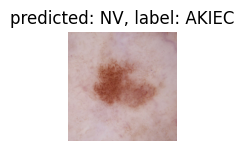

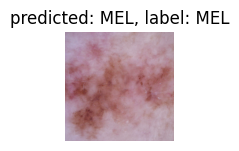

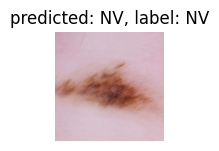

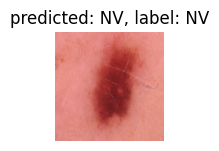

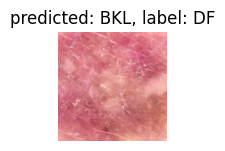

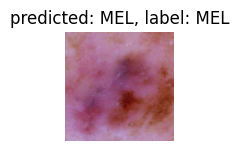

In [30]:
visualize_model(model, dataloaders['val'])

In [31]:
test_ds = ISICDataset(test_csv, test_dir, transform=data_transforms['val'])
test_loader = DataLoader(test_ds, batch_size=10, shuffle=False)

In [32]:
test_preds = make_predictions(model, test_loader)

In [33]:
prediction_csv = pd.read_csv(test_csv)
for idx in range(len(prediction_csv)):
    prediction_csv.iloc[idx, 1:] = test_preds[idx]


In [34]:
prediction_csv.to_csv('/content/drive/MyDrive/Colab Notebooks/Preds/predictions2.csv', index=None)